<a href="https://colab.research.google.com/github/alexanderdrent/Uncertainty-Analysis-Windmaster/blob/master/python_src/Windmaster_ET-Feature%20Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install ema_workbench and SALib
!pip install ema_workbench
!pip install SALib

     |████████████████████████████████| 23.7MB 1.4MB/s 
  Created wheel for ema-workbench: filename=ema_workbench-2.0.8-cp36-none-any.whl size=23772558 sha256=46187bc2caec353b0c332be419fccd45638e548d4982693123ac62cbd5d69641
  Stored in directory: /root/.cache/pip/wheels/62/ef/66/b32ebb75d741a7582de4a92dff6a0c9ffe84454919e8a12bfa
Successfully built ema-workbench
     |████████████████████████████████| 860kB 7.2MB/s 
  Created wheel for SALib: filename=SALib-1.3.11-py2.py3-none-any.whl size=729664 sha256=e97e1df253b36ba266f2ff74e2cc617127b0fd656a8edd07aa5f953cf15c9bea
  Stored in directory: /root/.cache/pip/wheels/62/ed/f9/a0b98754ffb2191b98324b96cbbeb1bd5d9598b39ab996b429
Successfully built SALib


In [ ]:
# load packages
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
import json

from ema_workbench.util.utilities import load_results
from ema_workbench.analysis import (feature_scoring, plotting,
                                    pairs_plotting, get_ex_feature_scores)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.analysis.plotting import kde_over_time, lines, multiple_densities
from ema_workbench.analysis.pairs_plotting import pairs_density, pairs_lines, pairs_scatter

from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ema_workbench/em_framework/evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
/usr/local/lib/python3.6/dist-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

# Load and merge results

results_1 = load_results('../EPA/Master Thesis/Results/5000 scenarios_MC_96-1.tar.gz')
results_2 = load_results('../EPA/Master Thesis/Results/5000 scenarios_MC_96-2.tar.gz')
results_3 = load_results('../EPA/Master Thesis/Results/1000 scenarios_MC.tar.gz')

experiments_1, outcomes_1 = results_1
experiments_2, outcomes_2 = results_2
experiments_3, outcomes_3 = results_3
experiments = pd.concat([experiments_1, experiments_2, experiments_3], ignore_index=True)
experiments.drop(['policy', 'model'], axis=1, inplace=True)
experiments.drop(labels = [43, 96, 5004], axis=0, inplace=True )
experiments.reset_index(drop=True, inplace=True)

outcomes = {}
for ooi in outcomes_1:
  outcomes[ooi] = np.concatenate((outcomes_1[ooi],outcomes_2[ooi], outcomes_3[ooi]))
  outcomes[ooi] = np.delete(arr = outcomes[ooi], obj = [43, 96, 5004], axis=0)

# construct two KPI's
outcomes['tennet_used_capacity'] = outcomes['tennet_load'] / outcomes['tennet_capacity'] * 100
outcomes['total_capex'] = outcomes['stedin capex'] + outcomes['tennet capex'] + outcomes['gasunie capex'] + outcomes['collaborative capex']

# load investment_ids for investments
investment_id = pd.read_csv('../EPA/Master Thesis/Results/investIDwindmaster.csv')['InvestID'].values

investments_per_experiment = pd.DataFrame(np.mean(outcomes['investments'], axis=1),
                                          columns=investment_id)

In [ ]:
# Calculate outcome means for the replications per experiment

outcomes_mean = {}
for outcome in ['stedin_capacity', 'stedin_load', 'tennet_capacity',
                'tennet_load', 'gasunie_capacity',
                'stedin capex', 'tennet capex', 'gasunie capex',
                'collaborative capex', 'h2_import', 'stedin_lost',
                'missed_over_time', 'first_failure', 'total_capex',
                'tennet_used_capacity']:
  outcomes_mean[outcome] = outcomes[outcome].mean(axis=1)

# Subdivide uncertainties (integers, categorical, boolean and real)

unc_int_years = ['C3 year', 'C6 year',
              'timing CCS',
              'year end demand gas Roterdam', 'year of introduction ELECTROLYSIS_H20',
              'yearBPOffline', 'yearGunvorPhaseout',
              'yearKochPhaseout']

unc_int = ['random-seed', 'easterly demand H2']

unc_cat = ['BOILER paths', 'COGEN paths', 'FURNACE paths',
           'SF factory 2032 location', 'SF factory 2036 location',
           'SF factory 2040 location', 'SF factory 2044 location',
           'SF factory 2048 location', 'SMR paths', 'decisionMakingModel',
           'location h2 production', 
           ]
unc_bool = ['shuffle-needed-investments?', 'offshore wind growth',
            'yearHydrocrackerBP', 'baseload biomass or closure C3',
            'baseload biomass or closure C6',]

unc_real = ['capex_factor', 'leadtime_factor']

# Determine KPI's and construct dict 
# kpi_dict = {original_ parameter_name: [Long description (for titles), short name with unit (for y-axis), short name]}

kpi_dict = {'missed_over_time': ['Missed Transition Pathway Events', 'Missed Events (#)', 'Missed Events'],
            'investments': ['Realized Infrastructure Investments', 'Investments (#)', 'Investments'],
            'tennet_used_capacity': ['Used Capacity of TenneT\'s Infrastructure', 'Used Capacity (%)', 'Used Capacity TenneT'],
            'total_capex': ['Capital Expenditure of all Infrastructure Parties', 'CAPEX (\u20ac)', 'Total CAPEX']}

kpi_over_time = ['missed_over_time', 'tennet_used_capacity', 'total_capex']

# store KPIs in seperate dict 
outcomes_mean_kpi = {}
for kpi in kpi_over_time:
  outcomes_mean_kpi[kpi] = outcomes_mean[kpi]

# for the KPI's over time (missed over time, tennet used capacity, total capex) calculate the development over time and store in seperate dict
# for Missed over time and total capex: cumsum. Tennet used capacity remains the same. 
outcomes_mean_kpi_over_time = {}
outcomes_mean_kpi_over_time['missed_over_time'] = outcomes_mean['missed_over_time'].cumsum(axis=1)
outcomes_mean_kpi_over_time['tennet_used_capacity'] = outcomes_mean['tennet_used_capacity']
outcomes_mean_kpi_over_time['total_capex'] = outcomes_mean['total_capex'].cumsum(axis=1)

# store KPI's in long form dataframe for line plotting
outcomes_mean_kpi_longform = {}
outcomes_mean_kpi_over_time_longform = {}
for kpi in kpi_over_time:
  outcomes_mean_kpi_longform[kpi] = pd.DataFrame(outcomes_mean_kpi[kpi])
  outcomes_mean_kpi_longform[kpi]['decisionMakingModel'] = experiments.decisionMakingModel
  outcomes_mean_kpi_longform[kpi]['experiment'] = experiments.index.values
  outcomes_mean_kpi_longform[kpi] = pd.melt(frame = outcomes_mean_kpi_longform[kpi],
                                            id_vars=['decisionMakingModel', 'experiment'],
                                            value_vars=np.arange(0, outcomes_mean_kpi[kpi].shape[1]),
                                            var_name='year',
                                            value_name=kpi)
  outcomes_mean_kpi_longform[kpi].year += 2020
  outcomes_mean_kpi_over_time_longform[kpi] = pd.DataFrame(outcomes_mean_kpi_over_time[kpi])
  outcomes_mean_kpi_over_time_longform[kpi]['decisionMakingModel'] = experiments.decisionMakingModel
  outcomes_mean_kpi_over_time_longform[kpi]['experiment'] = experiments.index.values
  outcomes_mean_kpi_over_time_longform[kpi] = pd.melt(frame = outcomes_mean_kpi_over_time_longform[kpi],
                                                      id_vars=['decisionMakingModel', 'experiment'],
                                                      value_vars=np.arange(0, outcomes_mean_kpi_over_time[kpi].shape[1]),
                                                      var_name='year',
                                                      value_name=kpi)
  outcomes_mean_kpi_over_time_longform[kpi].year += 2020

In [ ]:
# set general figure aesthetics 
sns.set_context("paper")
sns.set_style("ticks")
cmap = 'gist_heat'
cmap_r = 'gist_heat_r'
color = "#9B2D1F"
palette = "OrRd"
sns.set_palette('rocket')

In [ ]:
def save_fig(fig, name,dir='../EPA/Master Thesis/Results/Figures',dpi=300):
    fig.savefig('{}/fig_{}_{}dpi.png'.format(dir, name, dpi), dpi=dpi, 
                bbox_inches='tight', format='png')

In [ ]:
for unc in unc_int_years:
    sns.distplot(experiments[unc], kde=True, color=color)
    plt.show()

In [ ]:
for unc in unc_int:
    sns.distplot(experiments[unc], kde=True, color=color)
    plt.show()

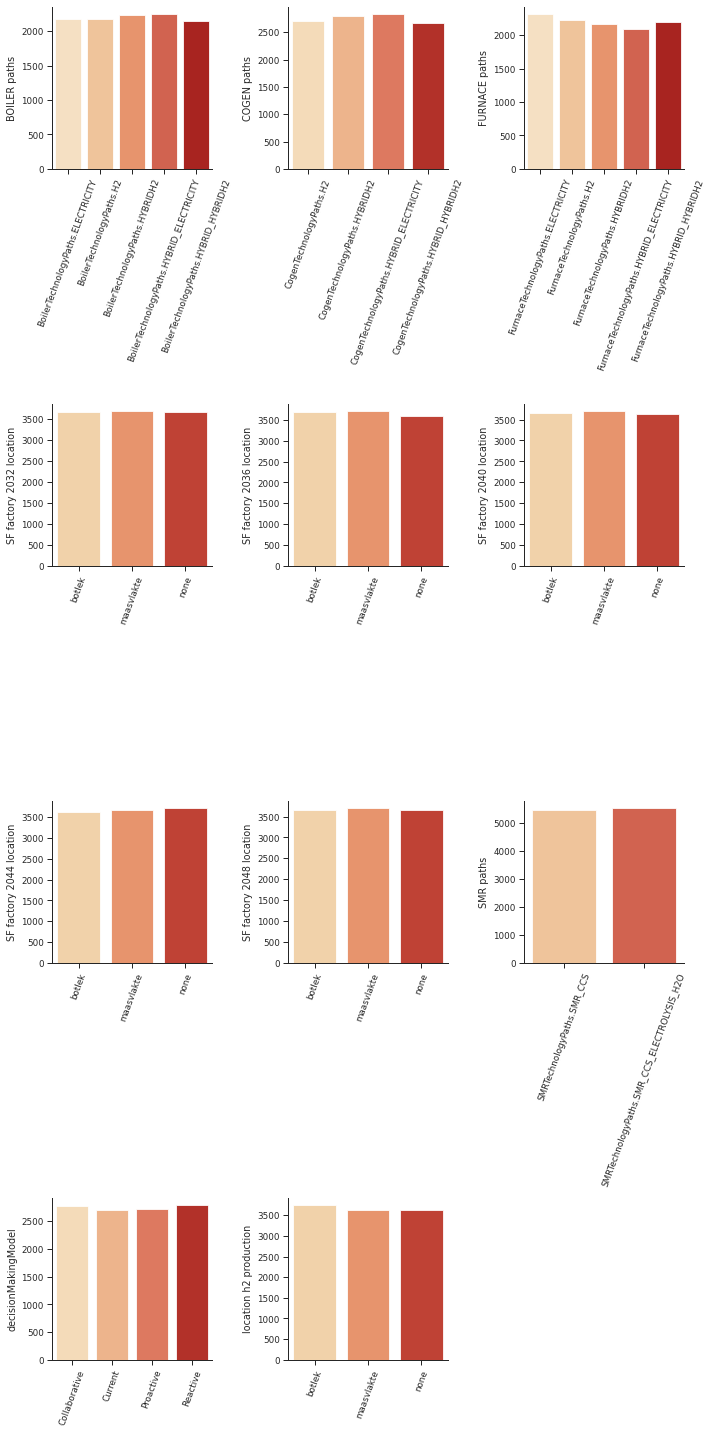

In [ ]:
fig = plt.figure(figsize=(10,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = {}
for i, unc in enumerate(unc_cat, start = 1):
    axes[i] = fig.add_subplot(4, 3, i)
    x = experiments[unc].value_counts().index
    y = experiments[unc].value_counts()
    axes[i] = sns.barplot(x =x, y=y, palette=palette, ax = axes[i])
    axes[i].tick_params('x', labelrotation=70)
fig.tight_layout()
#fig.suptitle("Bar Plot for all Categorical Uncertainties", size=13)
sns.despine()
plt.show()

save_fig(fig, name="Bar Plot for all Categorical Uncertainties")

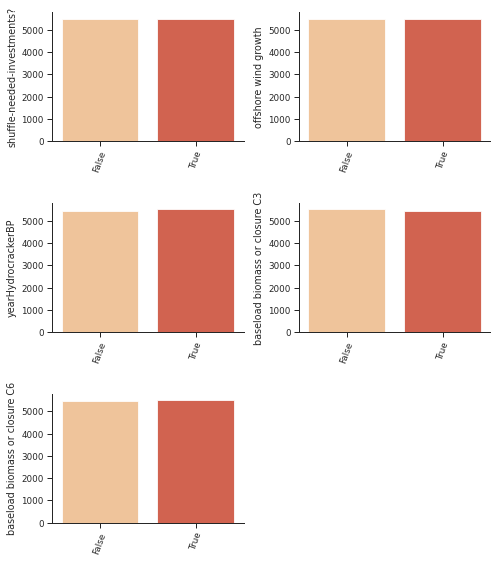

In [ ]:
fig = plt.figure(figsize=(7,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = {}
for i, unc in enumerate(unc_bool, start = 1):
    axes[i] = fig.add_subplot(3, 2, i)
    x = experiments[unc].value_counts().index
    y = experiments[unc].value_counts()
    axes[i] = sns.barplot(x =x, y=y, palette=palette, ax = axes[i])
    axes[i].tick_params('x', labelrotation=70)
fig.tight_layout()
#fig.suptitle("Bar Plot for all Categorical Uncertainties", size=13)
sns.despine()
plt.show()

save_fig(fig, name="Bar Plot for all Boolean Uncertainties")

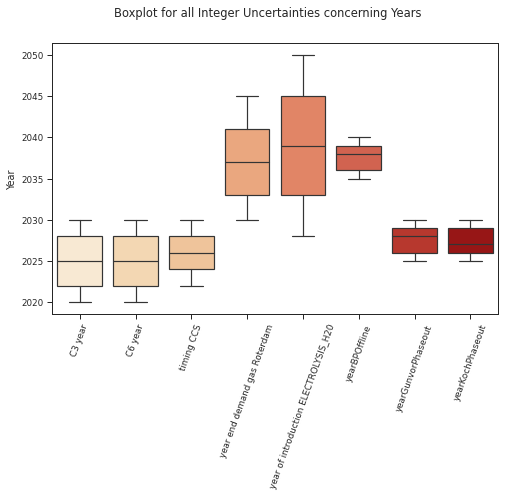

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(data=experiments[unc_int_years], palette = palette)
plt.xticks(rotation=70)
fig.set_size_inches(8,5)
fig.suptitle("Boxplot for all Integer Uncertainties concerning Years")
ax.set_ylabel("Year")
plt.show()
save_fig(fig, name="Boxplot for all Integer Uncertainties (years)")

In [ ]:
list(unc_int + unc_int_years + unc_real)

['random-seed',
 'easterly demand H2',
 'C3 year',
 'C6 year',
 'timing CCS',
 'year end demand gas Roterdam',
 'year of introduction ELECTROLYSIS_H20',
 'yearBPOffline',
 'yearGunvorPhaseout',
 'yearKochPhaseout',
 'capex_factor',
 'leadtime_factor']

In [ ]:
data=experiments[unc_int + unc_int_years + unc_real]

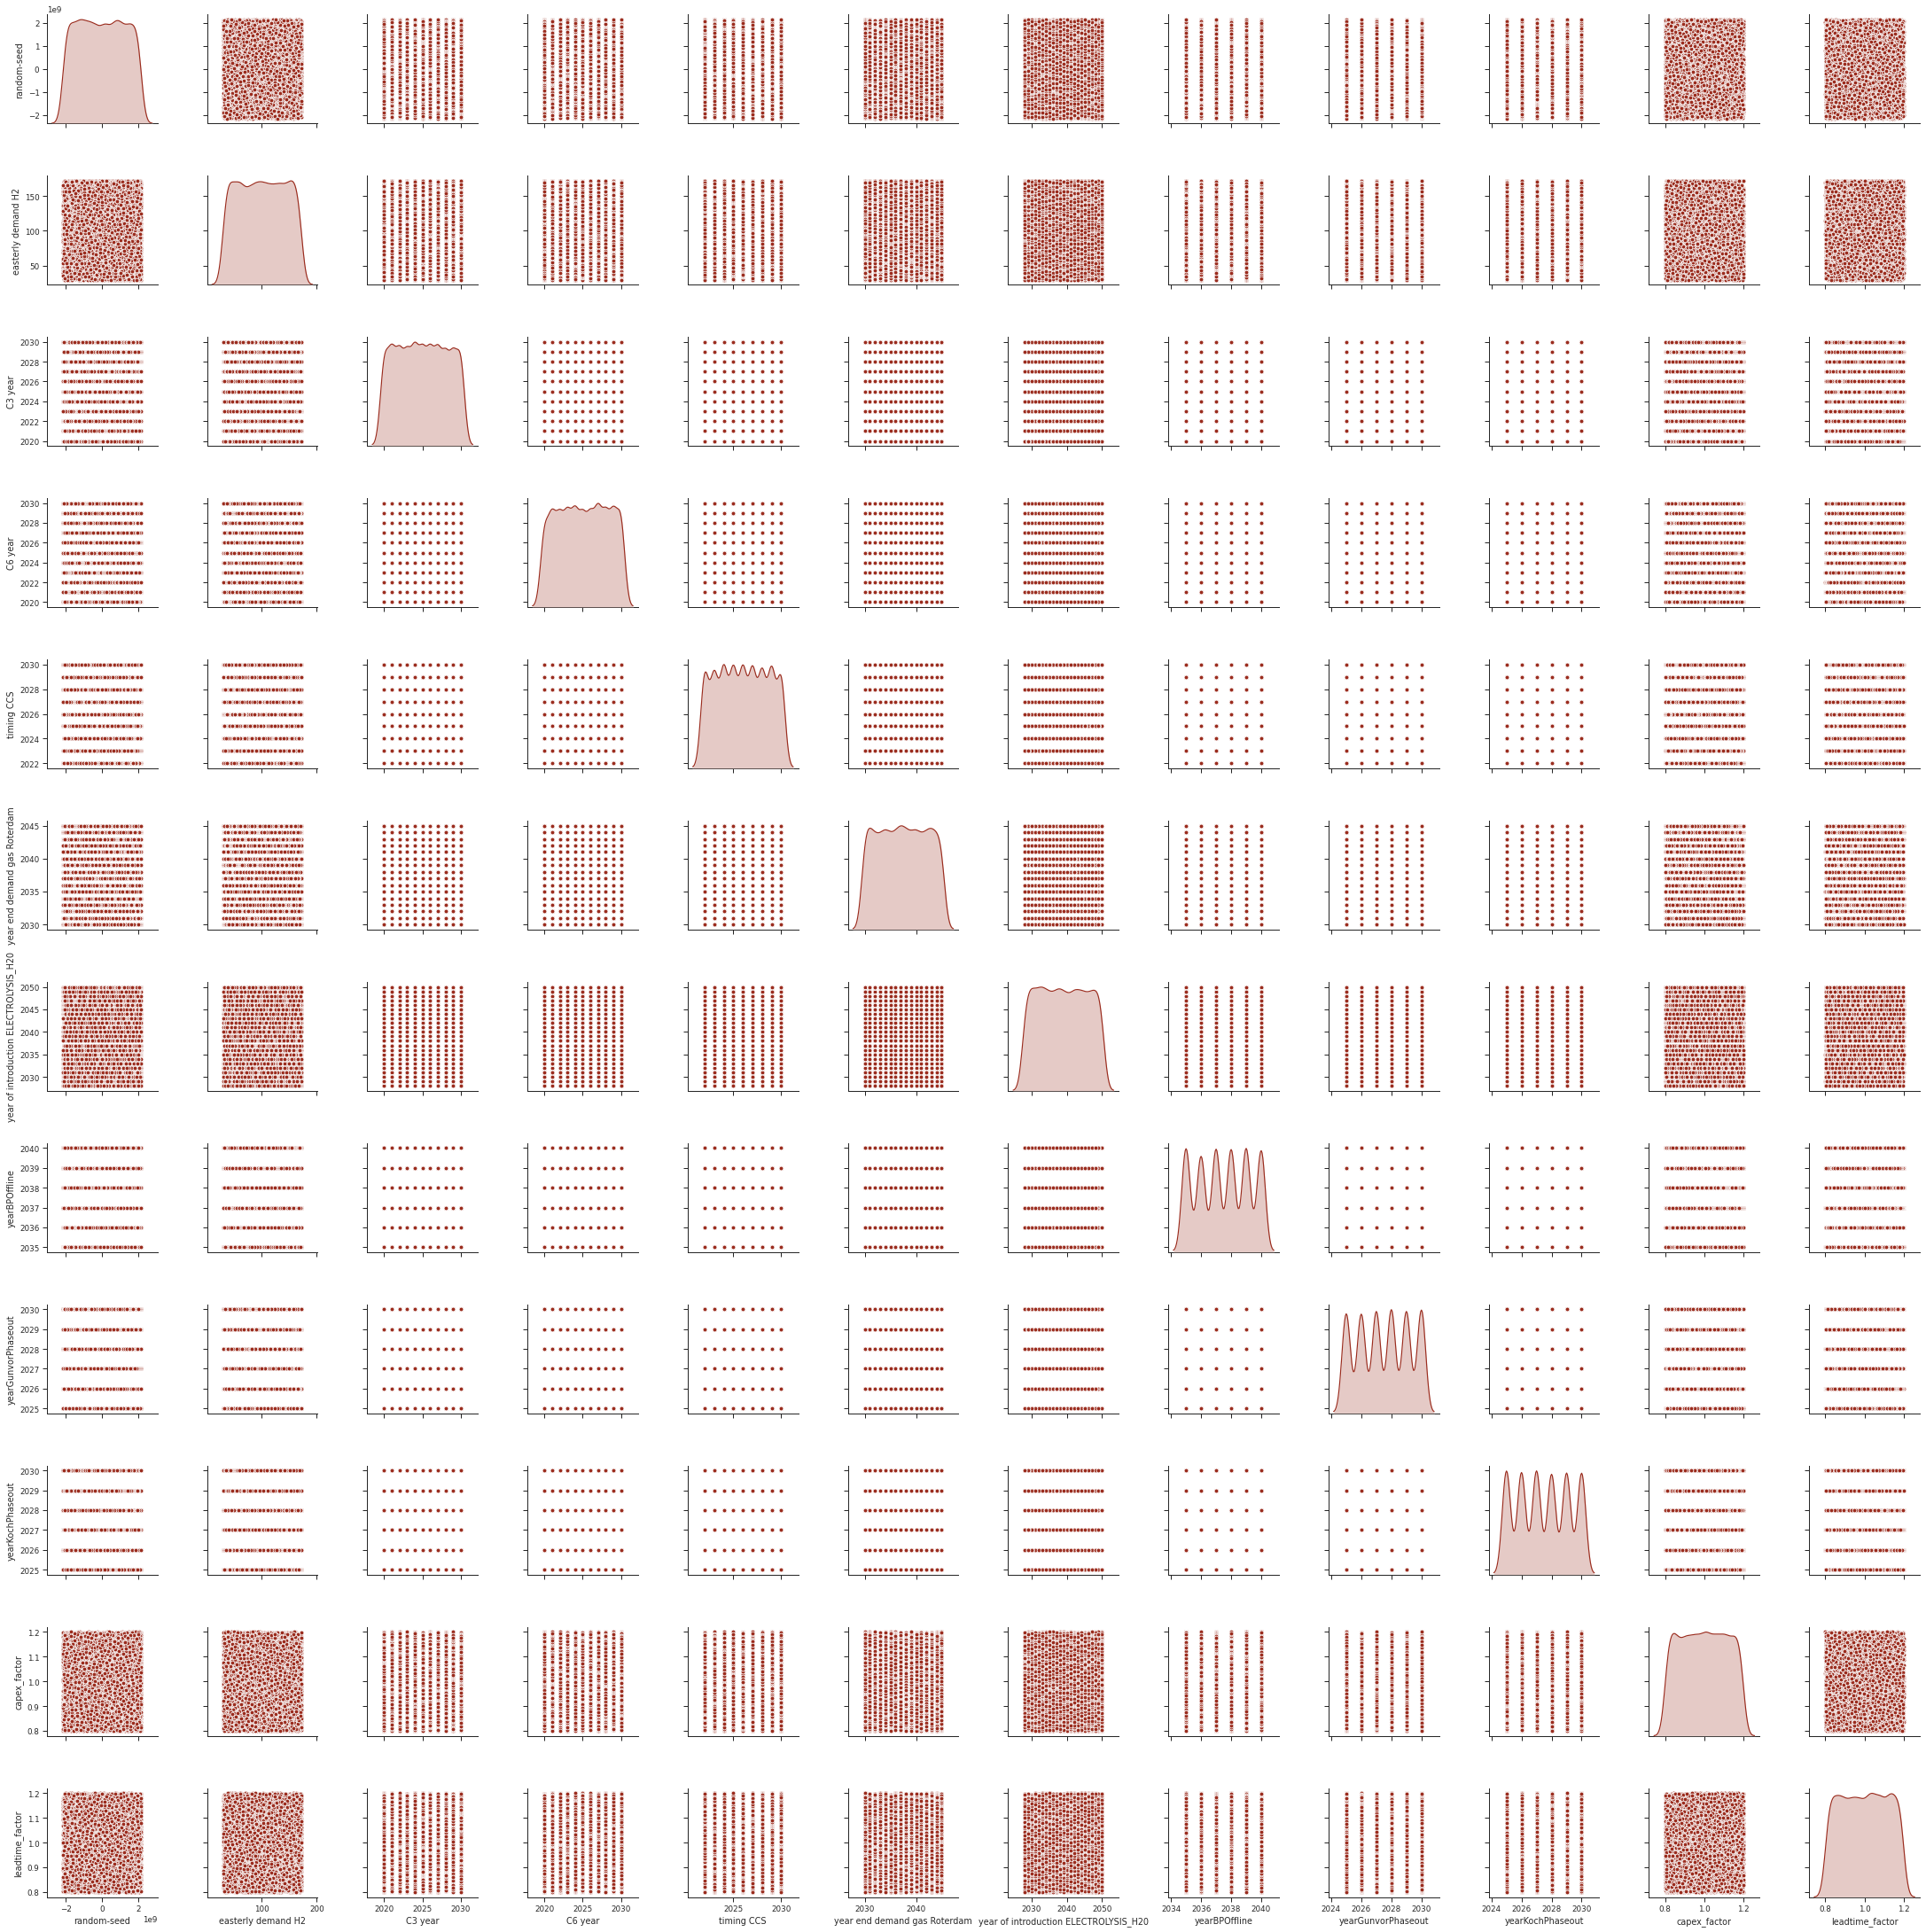

In [ ]:
pairgrid = sns.pairplot(data,
                        kind= 'scatter',
                        diag_kind="kde",
                        plot_kws={'color':color},
                        diag_kws={'shade':True, 'color':color})
plt.show()

save_fig(pairgrid.fig, name='pairplot_experiments')

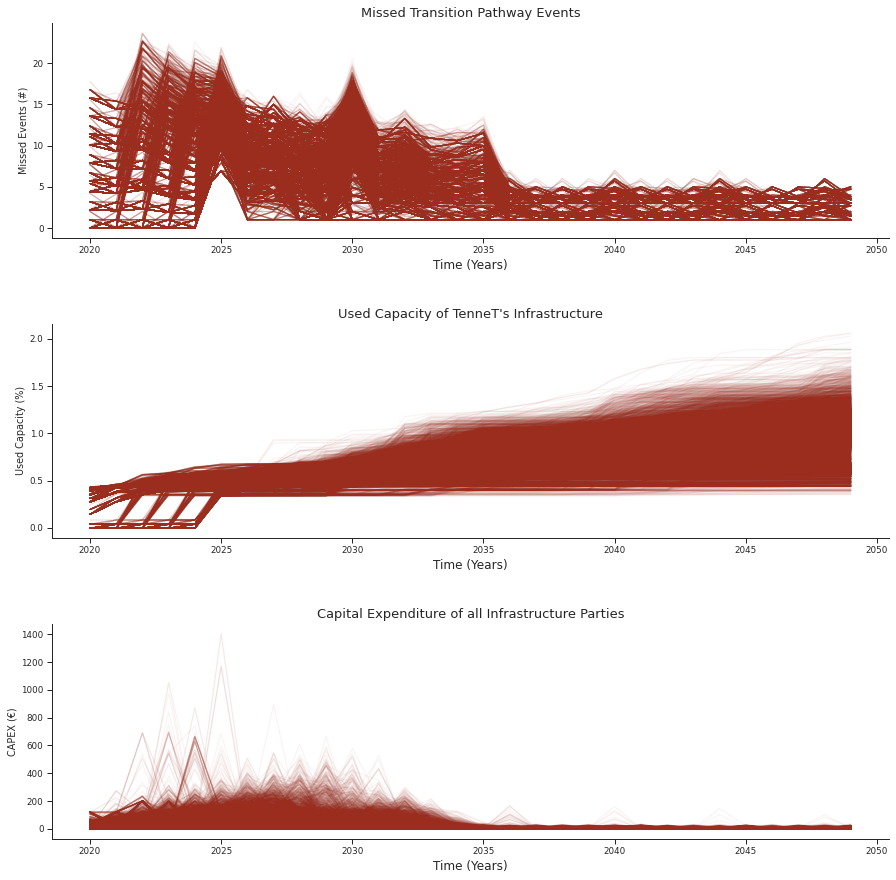

In [ ]:
fig, axes = lines(experiments = experiments,
                  outcomes = outcomes_mean_kpi)
for ax in kpi_over_time:
  axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()+2020, dtype=int))
  axes[ax].set_ylabel(kpi_dict[ax][1])
  axes[ax].set_xlabel("Time (Years)", size=12)
  axes[ax].set_title(kpi_dict[ax][0], size=13)
  for line in axes[ax].get_lines():
      line.set_alpha(0.05)
      line.set_color(color)
fig.set_size_inches (15,15)
sns.despine()
plt.show()

save_fig(fig, name='lineplots_KPI')

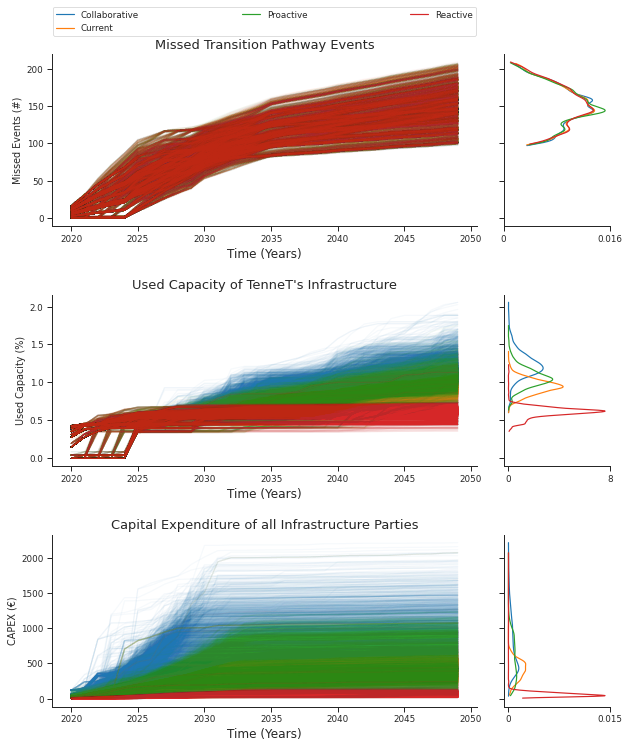

In [ ]:
fig, axes = lines(experiments, outcomes_mean_kpi_over_time, 
                group_by='decisionMakingModel', density=plotting.Density.KDE)
fig.set_size_inches(10,12)
for ax in kpi_over_time:
  axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()+2020, dtype=int))
  axes[ax].set_ylabel(kpi_dict[ax][1])
  axes[ax].set_xlabel("Time (Years)", size=12)
  axes[ax].set_title(kpi_dict[ax][0], size=13)
  for line in axes[ax].get_lines():
    line.set_alpha(0.04)
sns.despine()
plt.show()

save_fig(fig, name='cumulative KPIs over time with KDE per DM')

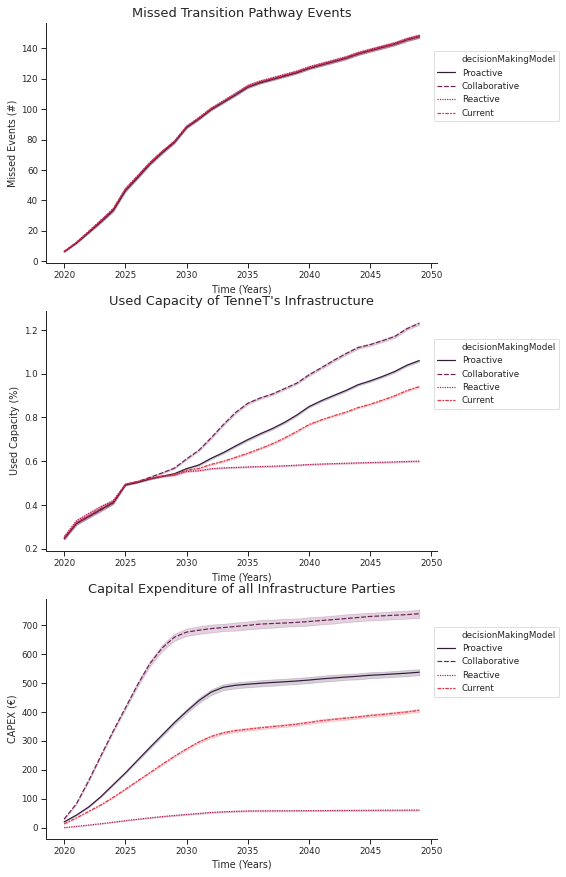

In [ ]:
fig, axes = plt.subplots(3, figsize=(7, 15))
for ax, kpi in enumerate(kpi_over_time):
  axes[ax] = sns.lineplot(data = outcomes_mean_kpi_over_time_longform[kpi],
                    x = 'year',
                    y=kpi,
                    hue='decisionMakingModel',
                    style='decisionMakingModel',
                    ax=axes[ax])
  axes[ax].set_title(kpi_dict[kpi][0], size=13)
  axes[ax].set_xlabel("Time (Years)")
  axes[ax].set_ylabel(kpi_dict[kpi][1])
  axes[ax].legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
  sns.despine()

plt.show()
save_fig(fig, name='lineplots_cumulative_KPI_grouped_by_DM')

In [ ]:
scores_mean_kpi_over_time = feature_scoring.get_feature_scores_all(experiments, outcomes_mean_kpi_over_time)

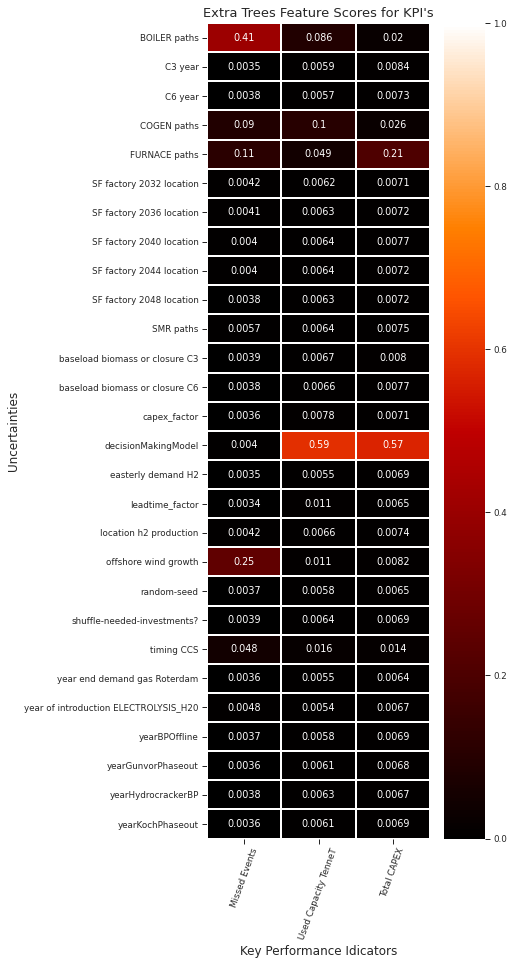

In [ ]:
fig, ax = plt.subplots(figsize=(5, 15))
ax = sns.heatmap(scores_mean_kpi_over_time, annot=True,
                 cmap = cmap,
                 vmin = 0, vmax = 1,
                 xticklabels = [kpi_dict[ooi][2] for ooi in scores_mean_kpi_over_time.columns],
                 yticklabels = 1,
                 linewidths=1)
ax.tick_params('x', labelrotation=70)
ax.set_title("Extra Trees Feature Scores for KPI's", size=13)
ax.set_xlabel("Key Performance Idicators", size = 12)
ax.set_ylabel("Uncertainties", size=12)
plt.show()

# save_fig(fig, name='Feature Scores for (cumulative) KPIs')

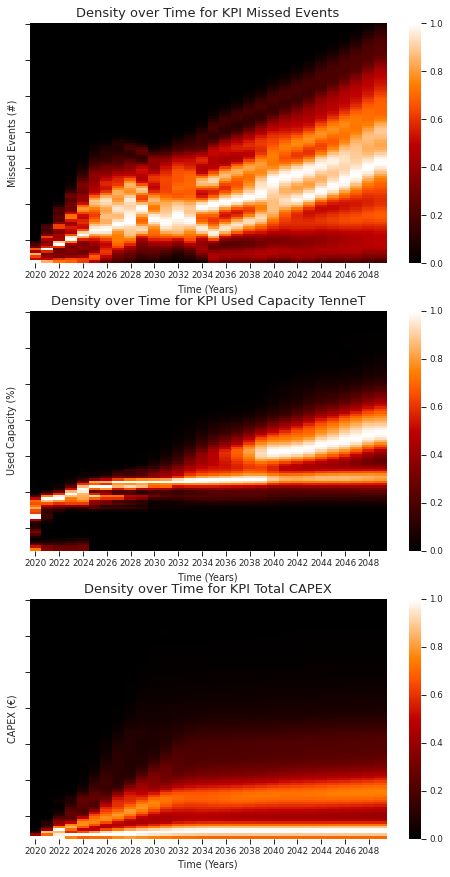

In [ ]:
# outcomes_to_show = ['tennet_used_capacity', 'total_capex']
fig, axes = kde_over_time(experiments,
                          outcomes_mean_kpi_over_time,
                          # outcomes_to_show = outcomes_to_show,
                          colormap=cmap,
                          group_by = None,
                          log=False)
fig.set_size_inches(8,15)
fig.suptitle(t=None)
for ax in kpi_over_time:#outcomes_to_show:
  axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()+2020, dtype=int))
  axes[ax].set_ylabel(kpi_dict[ax][1])
  axes[ax].set_xlabel("Time (Years)")
  axes[ax].set_title(f"Density over Time for KPI {kpi_dict[ax][2]}", size=13)

plt.show()
save_fig(fig, name=f'Density over Time for KPIs')

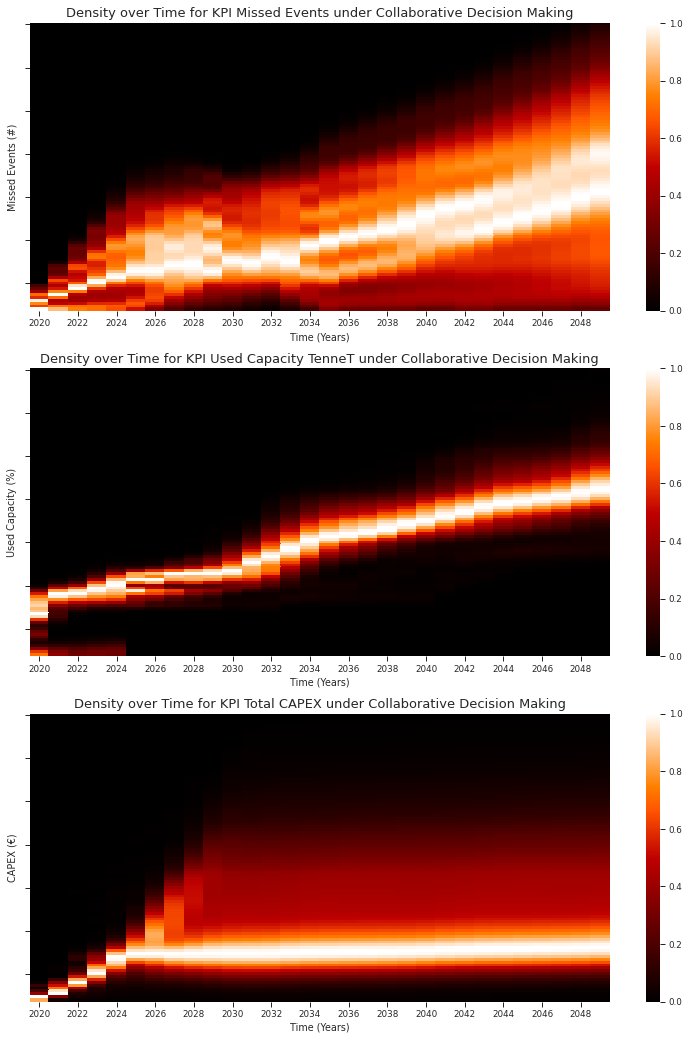

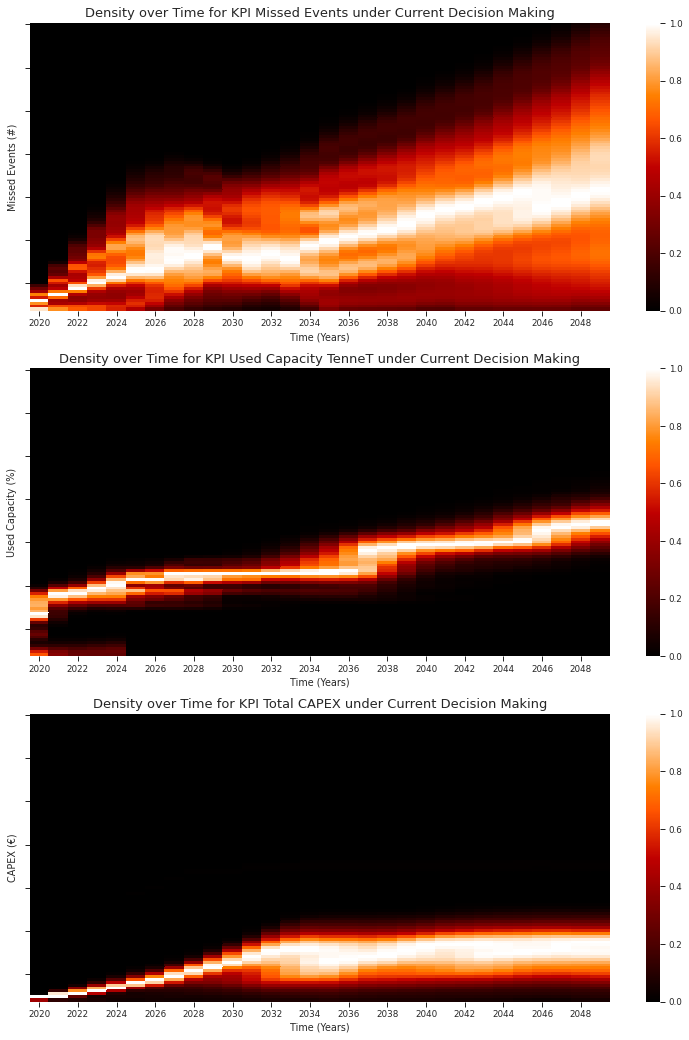

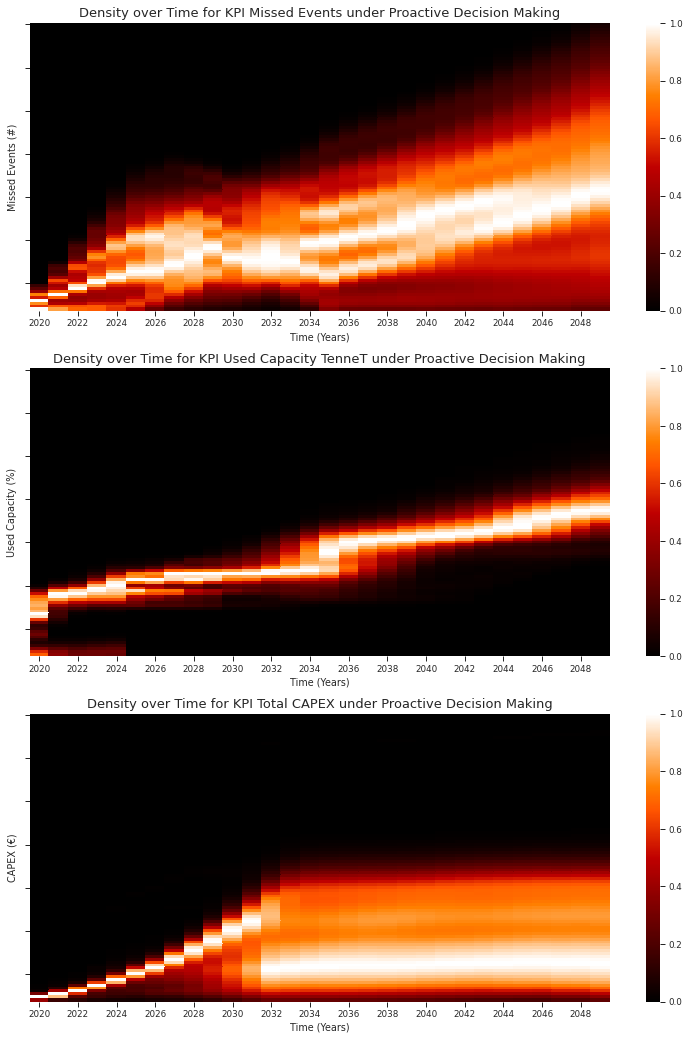

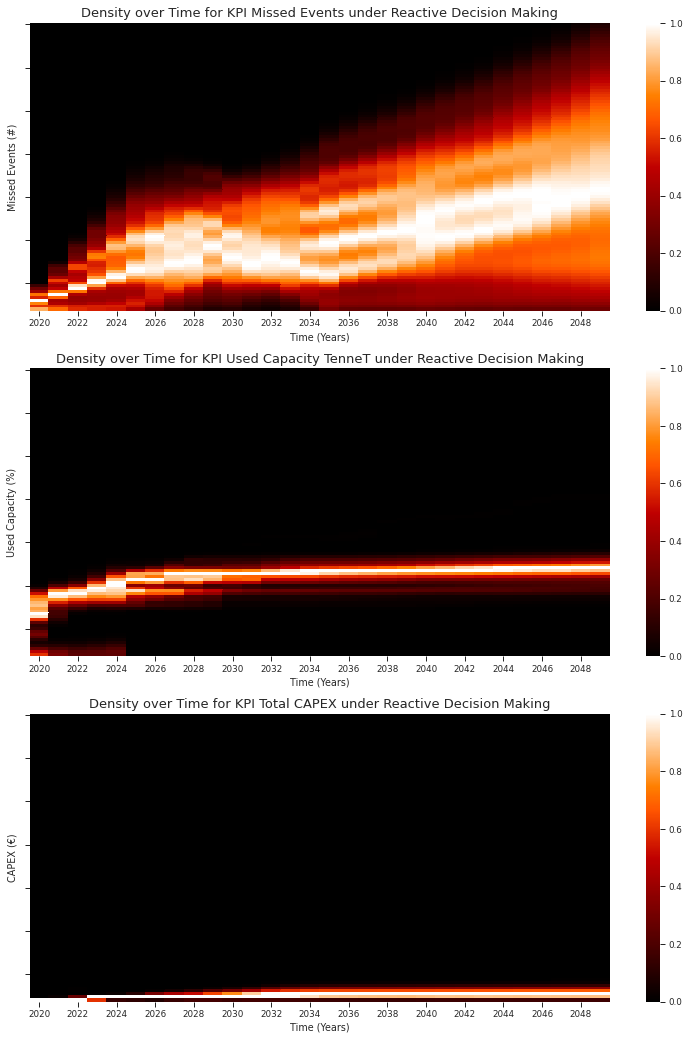

In [ ]:
# outcomes_to_show = ['tennet_used_capacity', 'total_capex']
figs, axes = kde_over_time(experiments,
                          outcomes_mean_kpi_over_time,
                          # outcomes_to_show = outcomes_to_show,
                          colormap=cmap,
                          group_by='decisionMakingModel',
                          log=False)
for fignr, dm in enumerate(axes.keys()):
  figs[fignr].set_size_inches(13,18)
  figs[fignr].suptitle(t=None)
  for ax in kpi_over_time:#outcomes_to_show:
    axes[dm][ax].set_xticklabels(np.array(axes[dm][ax].get_xticks()+2020, dtype=int))
   #axes[dm][ax].set_yticklabels(axes[dm][ax].get_yticks())
    # axes[dm]['tennet_used_capacity'].set_yticklabels(np.round(np.array(np.arange(0, 100, 5) / 100 * np.max(outcomes_mean_kpi_over_time['tennet_used_capacity']), dtype=float)[::-1],1))
    # axes[dm]['total_capex'].set_yticklabels(np.round(np.array(np.arange(0, 100, 5) / 100 * outcomes_mean_kpi_over_time['total_capex'].max(), dtype=float)[::-1],0))
    axes[dm][ax].set_ylabel(kpi_dict[ax][1])
    axes[dm][ax].set_xlabel("Time (Years)")
    axes[dm][ax].set_title(f"Density over Time for KPI {kpi_dict[ax][2]} under {dm} Decision Making", size=13)

  save_fig(figs[fignr], name=f'Density over Time for KPIs under {dm} DM')
    
plt.show()

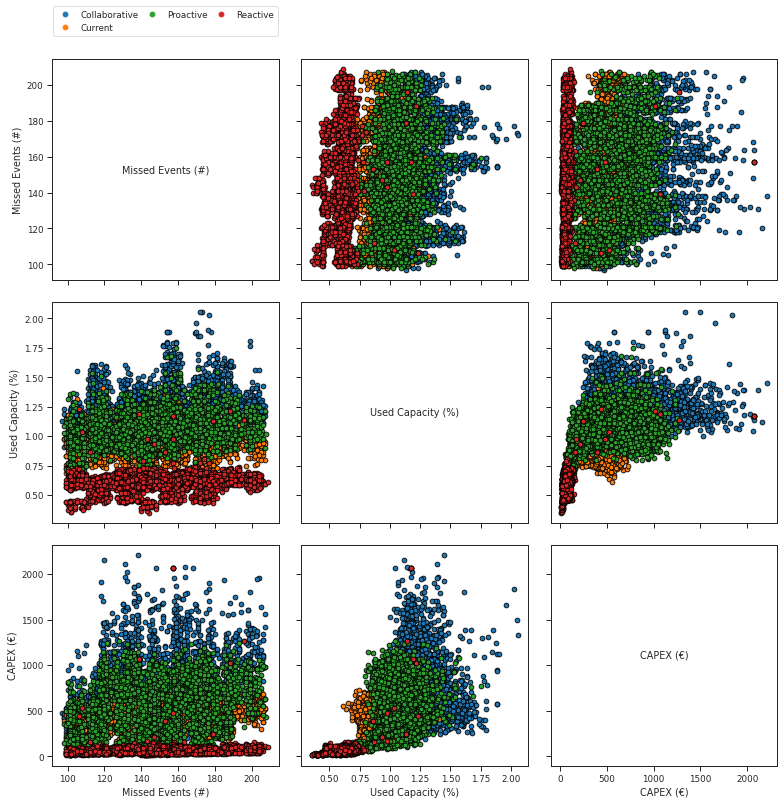

In [ ]:
fig, axes = pairs_scatter(experiments = experiments,
              outcomes = outcomes_mean_kpi_over_time,
              ylabels = {ooi: kpi_dict[ooi][1] for ooi in kpi_dict.keys()},
              group_by = 'decisionMakingModel',
              legend=True)
fig.set_size_inches (13,13)

plt.show()

save_fig(fig, name='pairs_scatter for KPIs')

In [ ]:
def get_ex_feature_scores_for_ooi (ooi):
    y = outcomes_mean_kpi_over_time[ooi]
    all_scores = []
    for i in range(0, y.shape[1], 1):
        data = y[:, i]
        scores = get_ex_feature_scores(experiments, data,
                                       mode=RuleInductionType.REGRESSION)[0]
        all_scores.append(scores)
    all_scores = pd.concat(all_scores, axis=1, sort=True)
    all_scores.columns = np.arange(2020, 2050, 1)
    return all_scores

def plot_heatmap_overtime (scores, ooi, annot):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(scores, cmap=cmap, vmin = 0, vmax = 1, annot = annot)
    ax.set_title('Extra Trees Feature Scores over Time for KPI ' +kpi_dict[ooi][2], size = 13)
    ax.set_xlabel("Time (Years)", size=12)
    ax.set_ylabel("Uncertainties", size=12)
    plt.show()    
    save_fig(fig, name=f'Feature Scores over time for {ooi}')

def plot_heatmap_overtime_for_variable(ooi, annot=False):
    all_scores = get_ex_feature_scores_for_ooi(ooi)
    plot_heatmap_overtime(all_scores, ooi, annot)

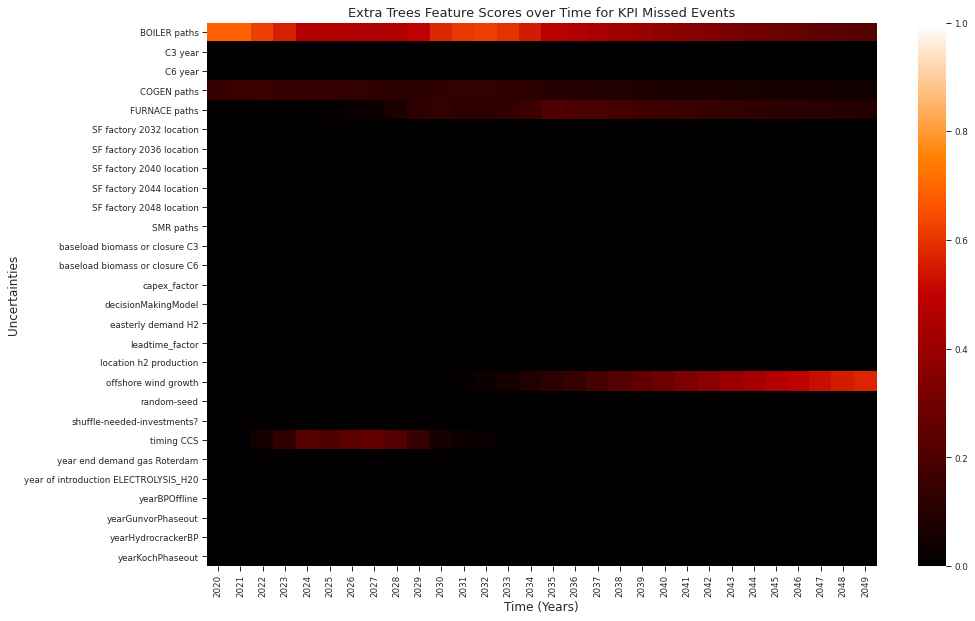

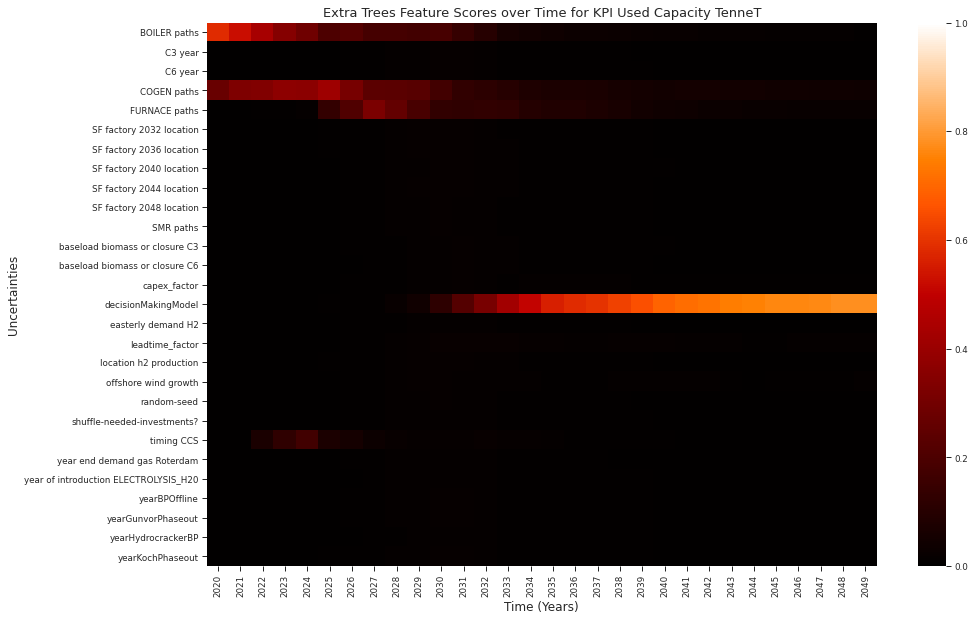

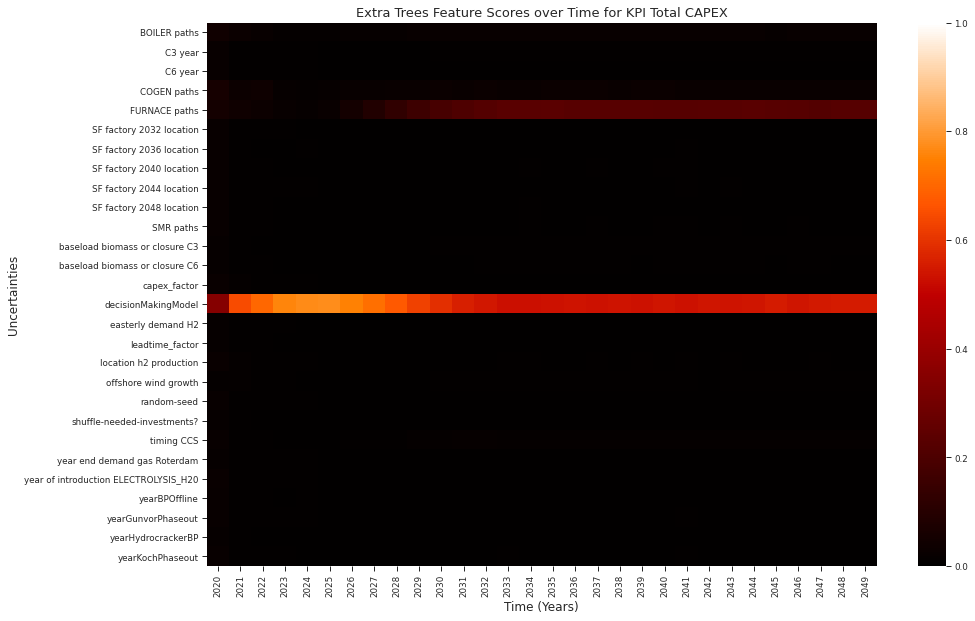

In [ ]:
for ooi in kpi_over_time:
    plot_heatmap_overtime_for_variable(ooi)
    

In [ ]:
def get_ex_feature_scores_convergence(interval, ooi):
    y = outcomes_mean_kpi_over_time[ooi]
    all_scores = []
    for i in range(interval, y.shape[0]+1, interval):
        x = experiments[0:i]
        data = y[0:i]
        scores = get_ex_feature_scores(x, data,
                                        mode=RuleInductionType.REGRESSION)[0]
        all_scores.append(scores)
    all_scores = pd.concat(all_scores, axis=1, sort=False)
    all_scores.columns = np.arange(interval, y.shape[0]+1, interval)
    return all_scores 

def plot_over_inscreasing_samples_for_ooi(ooi, top_x):
    all_scores = get_ex_feature_scores_convergence(ooi)
    all_scores = all_scores.sort_values(by = [10000], ascending = False)
    with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(figsize=(12, 4))
      ax = sns.lineplot(data=all_scores[0:top_x].T)
      ax.legend(loc='upper right')
      ax.set_title(f'Top {top_x} Extra Trees Feature Scores over Increasing Sample Size for KPI '
                  +kpi_dict[ooi][2], size = 13)
      ax.set_xlabel("Sample size (#)", size=12)
      ax.set_ylabel("Feature Score", size=12)
      ax.set_ylim(0, 1)
      plt.axvline(3000,  **{'linestyle': '--', 'color': "grey"})
      plt.show()
      save_fig(fig, name=f'Convergence of feature scores over increasing samples for {ooi}')

In [ ]:
for ooi in kpi_over_time:
    plot_over_inscreasing_samples_for_ooi(ooi, 5)

TypeError: ignored

In [ ]:
def get_ex_feature_scores_convergence_confidence(ooi):
    all_scores = []
    all_scores_min = []
    all_scores_max = []
    interval = 500
    y = outcomes_mean_kpi_over_time[ooi]
    for i in range(interval, y.shape[0]+1, interval):
        x = experiments[0:i]
        data = y[0:i]
        scores = get_ex_feature_scores(x, data,
                                        mode=RuleInductionType.REGRESSION)[0]
        all_scores.append(scores)
        min_bootstrapped_score, max_bootstrapped_score = get_bootstrapped_scores(i, ooi, int(i/20))
        all_scores_min.append(min_bootstrapped_score)
        all_scores_max.append(max_bootstrapped_score)

    all_scores = pd.concat(all_scores, axis=1, sort=False)
    all_scores.columns = np.arange(interval, y.shape[0]+1, interval)

    all_scores_min = pd.concat(all_scores_min, axis=1, sort=False)
    all_scores_min.columns = np.arange(interval, y.shape[0]+1, interval)

    all_scores_max = pd.concat(all_scores_max, axis=1, sort=False)
    all_scores_max.columns = np.arange(interval, y.shape[0]+1, interval)

    return all_scores, all_scores_min, all_scores_max

In [ ]:
def get_bootstrapped_scores_for_all_kpis(x, y, sample_size, nr_iterations):
    bootstrapped_scores = {}
    min_bootstrapped_score = {}
    max_bootstrapped_score = {}
    for ooi in kpi_over_time:
        bootstrapped_scores[ooi] = []
        min_bootstrapped_score[ooi] = []
        max_bootstrapped_score[ooi] = []
    for _ in range(nr_iterations):
        indices = np.random.choice(np.arange(0, x.shape[0]), size=x.shape[0])
        selected_x = x.iloc[indices, :]
        selected_y = {}
        for ooi in kpi_over_time:
            selected_y[ooi] = y[ooi][indices]

        scores = feature_scoring.get_feature_scores_all(selected_x, selected_y,
                                    mode=RuleInductionType.REGRESSION)
        for ooi in kpi_over_time:
            bootstrapped_scores[ooi].append(scores[ooi])
            
    for ooi in kpi_over_time:
        bootstrapped_scores[ooi] = pd.concat(bootstrapped_scores[ooi], axis=1, sort=False)
        min_bootstrapped_score[ooi] = bootstrapped_scores[ooi].min(axis=1)
        max_bootstrapped_score[ooi] = bootstrapped_scores[ooi].max(axis=1)
    return min_bootstrapped_score, max_bootstrapped_score

In [ ]:
def get_ex_feature_scores_convergence_confidence_for_all_kpis(interval):
    all_scores = {}
    all_scores_min = {}
    all_scores_max = {}
    y = outcomes_mean_kpi_over_time
    for ooi in kpi_over_time:
        all_scores[ooi] = []
        all_scores_min[ooi] = []
        all_scores_max[ooi] = []
    for i in range(interval, experiments.shape[0]+1, interval):
        outcomes_mean_kpi_over_time_for_sample_size = {}
        for ooi in kpi_over_time:
            outcomes_mean_kpi_over_time_for_sample_size[ooi] = outcomes_mean_kpi_over_time[ooi][:,-1][0:i]
        x = experiments[0:i]
        data = outcomes_mean_kpi_over_time_for_sample_size
        scores = feature_scoring.get_feature_scores_all(x, data,
                                        mode=RuleInductionType.REGRESSION)
        for ooi in kpi_over_time:
            all_scores[ooi].append(scores[ooi])
        min_bootstrapped_score, max_bootstrapped_score = get_bootstrapped_scores_for_all_kpis(x, data, i, int(i/10))
        for ooi in kpi_over_time:
            all_scores_min[ooi].append(min_bootstrapped_score[ooi])
            all_scores_max[ooi].append(max_bootstrapped_score[ooi])
    for ooi in kpi_over_time:
        all_scores[ooi] = pd.concat(all_scores[ooi], axis=1, sort=False)
        all_scores[ooi].columns = np.arange(interval, experiments.shape[0]+1, interval)

        all_scores_min[ooi] = pd.concat(all_scores_min[ooi], axis=1, sort=False)
        all_scores_min[ooi].columns = np.arange(interval, experiments.shape[0]+1, interval)

        all_scores_max[ooi] = pd.concat(all_scores_max[ooi], axis=1, sort=False)
        all_scores_max[ooi].columns = np.arange(interval, experiments.shape[0]+1, interval)

    return all_scores, all_scores_min, all_scores_max

In [ ]:
all_scores, all_scores_min, all_scores_max = get_ex_feature_scores_convergence_confidence_for_all_kpis(250)

In [ ]:
# 23,650 repeated calculations of feature scores may take a long time, so better save the results to csv 
for ooi in kpi_over_time:
    all_scores_min[ooi].to_csv(f"../EPA/Master Thesis/Results/ET-Feature scores/all_scores_min_250_{ooi}.csv")
    all_scores_max[ooi].to_csv(f"../EPA/Master Thesis/Results/ET-Feature scores/all_scores_max_250_{ooi}.csv")
    all_scores[ooi].to_csv(f"../EPA/Master Thesis/Results/ET-Feature scores/all_scores_250_{ooi}.csv")

In [ ]:
all_scores_min_pd={}
all_scores_max_pd={}
all_scores_pd={}

for ooi in kpi_over_time:
    all_scores_min_pd[ooi] = pd.read_csv(f"../EPA/Master Thesis/Results/ET-Feature scores/all_scores_min_250_{ooi}.csv", index_col = 0)
    all_scores_min_pd[ooi].sort_values(by='10000', ascending=False, inplace=True)
    all_scores_min_pd[ooi].columns = np.arange(250, 11000, 250)
    all_scores_max_pd[ooi] = pd.read_csv(f"../EPA/Master Thesis/Results/ET-Feature scores/all_scores_max_250_{ooi}.csv", index_col = 0)
    all_scores_max_pd[ooi].sort_values(by='10000', ascending=False, inplace=True)
    all_scores_max_pd[ooi].columns = np.arange(250, 11000, 250)
    all_scores_pd[ooi] = pd.read_csv(f"../EPA/Master Thesis/Results/ET-Feature scores/all_scores_250_{ooi}.csv", index_col = 0)
    all_scores_pd[ooi].sort_values(by='10000', ascending=False, inplace=True)
    all_scores_pd[ooi].columns = np.arange(250, 11000, 250)

In [ ]:
def plot_convergence_confidence_for_ooi(ooi):
     with sns.axes_style("whitegrid"):
        top_x = 4
        top_scores_unc = list(all_scores_pd[ooi][0:top_x].index)
        unc = top_scores_unc[0]
        fig, ax = plt.subplots(figsize=(12, 6))
        ax = sns.lineplot(data=all_scores_pd[ooi][0:top_x].T, sort=False)
        #ax = sns.lineplot(x = all_scores_pd[ooi].columns, y=all_scores_pd[ooi][0:top_x].T.squeeze())
       # ax = sns.lineplot(x = all_scores_pd[ooi].columns, y = "BOILER paths", data=all_scores_pd[ooi][0:top_x].T)
        ax.legend(loc='upper right')
        ax.set_title(f'Top {top_x} Extra Trees Feature Scores over Increasing Sample Size for KPI '
                    +kpi_dict[ooi][2], size = 13)
        ax.set_xlabel("Sample size (#)", size=12)
        ax.set_ylabel("Feature Score", size=12)
        ax.set_ylim(0, 1)
        plt.axvline(3000,  **{'linestyle': '--', 'color': "grey"})
        for unc in top_scores_unc:
            ax = plt.fill_between(x=all_scores_pd[ooi].columns, y1 = all_scores_min_pd[ooi].loc[unc].T.squeeze(), y2 = all_scores_max_pd[ooi].loc[unc].T.squeeze(), alpha=0.2)
        plt.show()
        save_fig(fig, name=f'Convergence and uplowlims of feature scores over increasing samples for {ooi}')

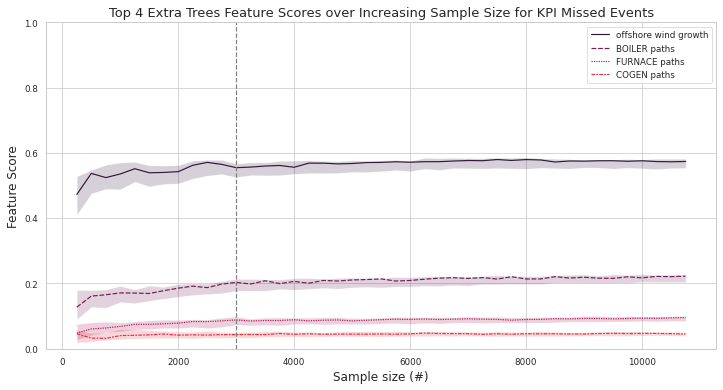

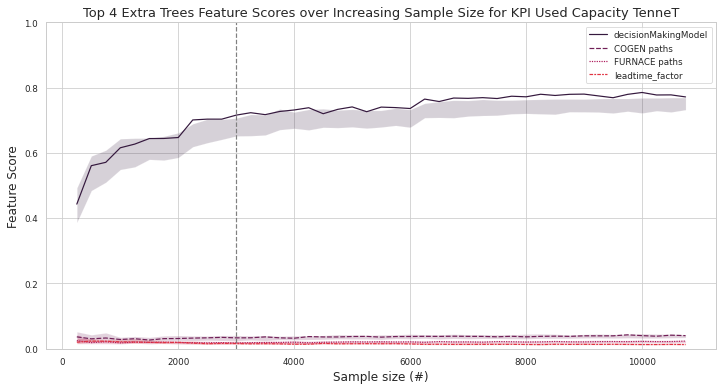

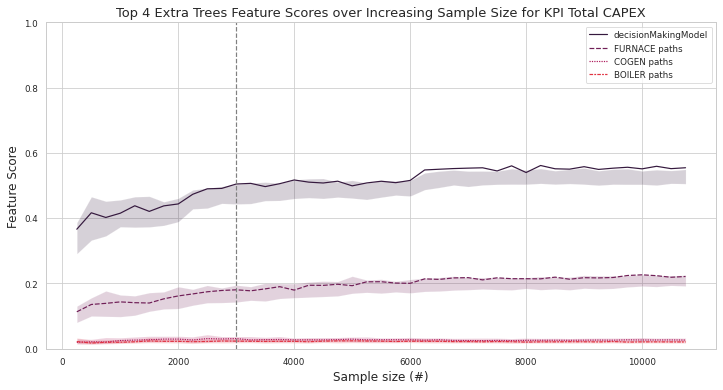

In [ ]:
for ooi in kpi_over_time:
    plot_convergence_confidence_for_ooi(ooi)

In [ ]:
def get_bootstrapped_scores(sample_size, ooi, nr_iterations):
  bootstrapped_scores = []
  x = experiments[:sample_size]
  y = outcomes_mean_kpi_over_time[ooi]
  for _ in range(nr_iterations):
      indices = np.random.choice(np.arange(0, x.shape[0]), size=x.shape[0])
      selected_x = x.iloc[indices, :]
      selected_y = y[indices]
      
      scores = get_ex_feature_scores(selected_x, selected_y,
                                    mode=RuleInductionType.REGRESSION)[0]
      bootstrapped_scores.append(scores)
  bootstrapped_scores = pd.concat(bootstrapped_scores, axis=1, sort=False)
  min_bootstrapped_score = bootstrapped_scores.min(axis=1)
  max_bootstrapped_score = bootstrapped_scores.max(axis=1)
  return min_bootstrapped_score, max_bootstrapped_score

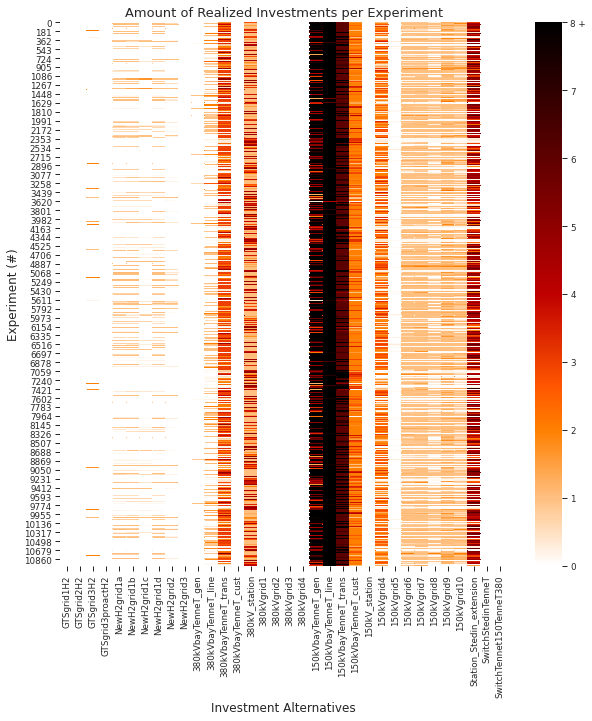

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
vmax = 8
ax = sns.heatmap(investments_per_experiment, cmap=cmap_r, vmax=vmax, cbar = True,
                      ax=ax)
ax.set_title("Amount of Realized Investments per Experiment", size = 13)
ax.set_ylabel("Experiment (#)", size=12)
ax.set_xlabel("Investment Alternatives", size=12)
cbar = ax.collections[-1].colorbar
cbar.set_ticks(list(range(0, vmax+1)))
labels = list(map(str, list(range(0,vmax))))
labels.append(str(vmax) + ' +')
cbar.set_ticklabels(labels)
plt.show()

# save_fig(fig, name='Amount of realized investments per experiment')

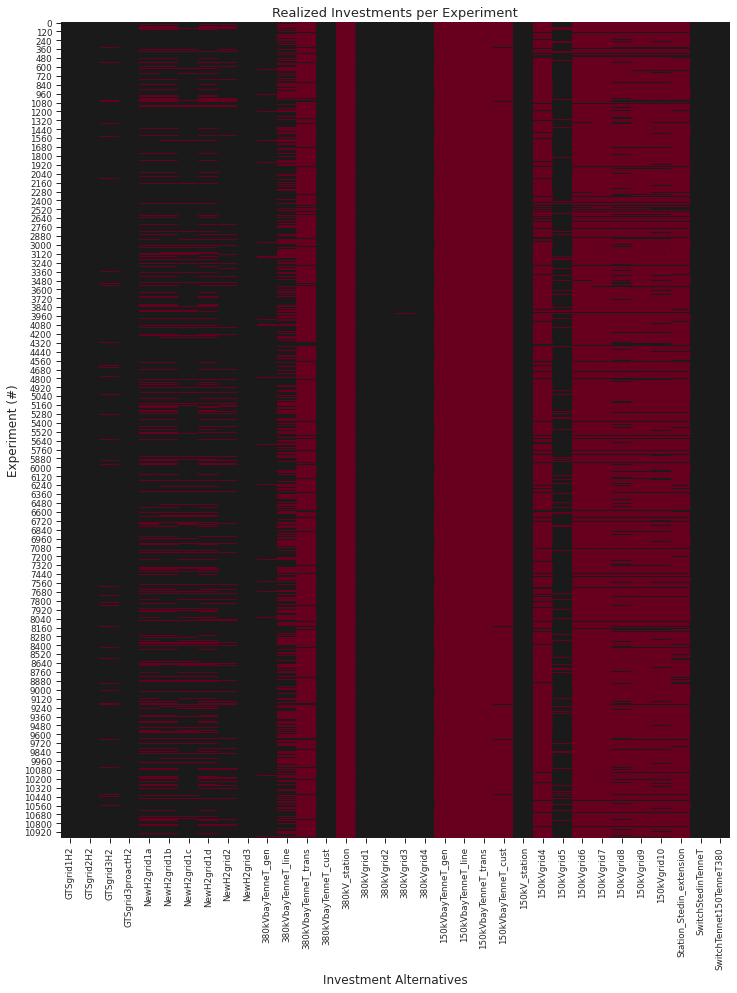

In [ ]:
fig, ax = plt.subplots(figsize=(12,15))
ax = sns.heatmap(investments_per_experiment>0, cbar=False, cmap='RdGy_r')
ax.set_title("Realized Investments per Experiment", size = 13)
ax.set_ylabel("Experiment (#)", size=12)
ax.set_xlabel("Investment Alternatives", size=12)
plt.show()

In [ ]:
scores_investments_per_experiment = feature_scoring.get_feature_scores_all(experiments, investments_per_experiment)

In [ ]:
high_scores_investments_per_experiment = scores_investments_per_experiment.loc[scores_investments_per_experiment.sum(axis=1).sort_values(ascending=False)[0:4].index]

In [ ]:
high_scores_investments_per_experiment = high_scores_investments_per_experiment[scores_investments_per_experiment.sum(axis=0).sort_values(ascending=False)[0:20].index]

In [ ]:
high_scores_investments_per_experiment

380kVbayTenneT_trans  ...  NewH2grid2
0                                          ...            
decisionMakingModel              0.661101  ...    0.381996
FURNACE paths                    0.050862  ...    0.152623
COGEN paths                      0.033510  ...    0.090587
BOILER paths                     0.039756  ...    0.051986

[4 rows x 20 columns]

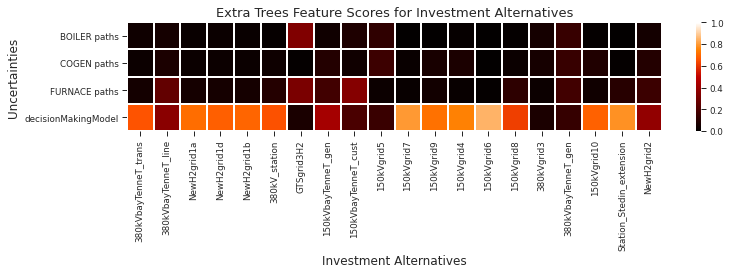

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2))
ax = sns.heatmap(high_scores_investments_per_experiment.sort_index(),
                 cmap=cmap,
                 vmin = 0, vmax = 1,
                 annot = False,
                 linewidths=1)
ax.set_title('Extra Trees Feature Scores for Investment Alternatives', size = 13)
ax.set_xlabel("Investment Alternatives", size=12)
ax.set_ylabel("Uncertainties", size=12)
plt.show()

save_fig(fig, name='Top Feature scores on top realized investments')

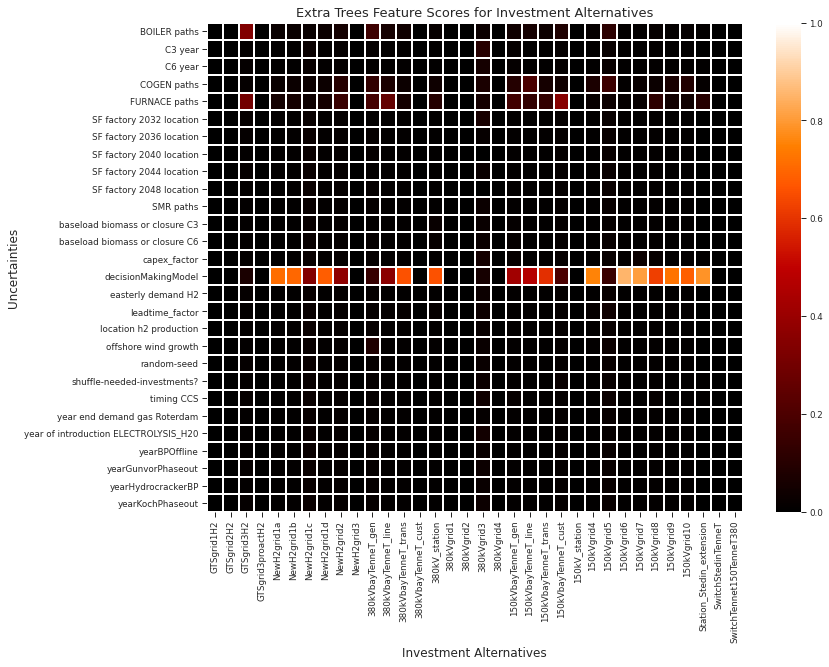

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(scores_investments_per_experiment.sort_index(),
                 cmap=cmap,
                 vmin = 0, vmax = 1,
                 annot = False,
                 linewidths=1)
ax.set_title('Extra Trees Feature Scores for Investment Alternatives', size = 13)
ax.set_xlabel("Investment Alternatives", size=12)
ax.set_ylabel("Uncertainties", size=12)
plt.show()

save_fig(fig, name='Feature scores on realized investments')

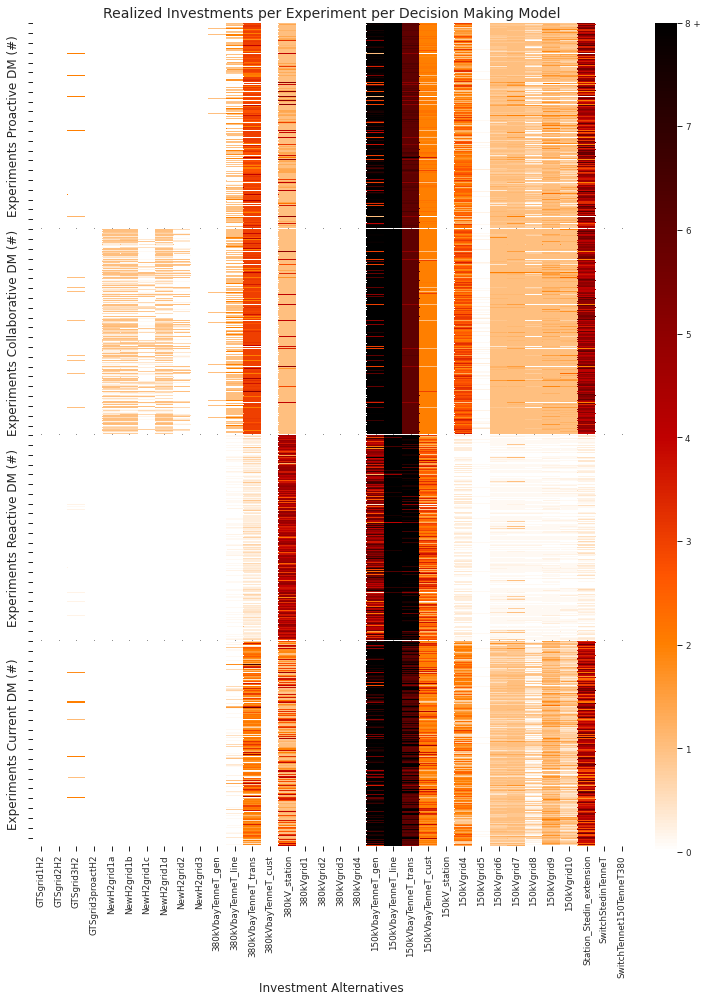

In [ ]:
fig, axes = plt.subplots(4, sharex=True, figsize=(10, 12))
fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([.91, .025, .03, 0.96])
vmax=8

for num, dm in enumerate(list(experiments.decisionMakingModel.unique())):
  investments_per_dm = pd.DataFrame(np.mean(outcomes['investments'], axis=1)[experiments.index[experiments.decisionMakingModel==dm]],
                      columns=investment_id)
  axes[num] = sns.heatmap(investments_per_dm, ax=axes[num],
                          cbar= num == 0, cmap=cmap_r, vmax=vmax,
                          cbar_ax = cbar_ax)
  axes[num].set_ylabel(f"Experiments {dm} DM (#)", size=12)
  axes[num].set_yticklabels([])
axes[3].set_xlabel("Investment Alternatives", size=12)
axes[0].set_title('Realized Investments per Experiment per Decision Making Model', size = 14)
labels = list(map(str, list(range(0,vmax))))
labels.append(str(vmax) + ' +')
cbar_ax.set_yticklabels(labels)
fig.subplots_adjust(wspace=0, hspace=0.005)
plt.show()

# save_fig(fig, name='Realized investments per DM')

In [ ]:
def get_ex_feature_scores_replication(ooi, top_x):
  rep_scores = []
  for rep in range(0, outcomes[ooi].shape[1]):
    data = outcomes[ooi][:,rep]
    scores = get_ex_feature_scores(experiments, data,
                                  mode=RuleInductionType.REGRESSION)[0]
    rep_scores.append(scores)
  rep_scores = pd.concat(rep_scores, axis=1, sort=False)
  rep_scores.columns = np.arange(0, rep+1)
  rep_scores.sort_values(by = [0], ascending = False, inplace=True)
  return rep_scores[0:top_x]

def plot_heatmap_per_replication(rep_scores, ooi, top_x):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax = sns.heatmap(rep_scores,
                  cmap=cmap,
                  vmin = 0, vmax = 1,
                  annot = True,
                  linewidths=1)
  ax.set_title('Extra Trees Feature Scores per Replication for KPI '
                +kpi_dict[ooi][2], size = 13)
  ax.set_xlabel("Replication (#)", size=12)
  ax.set_ylabel(f"Uncertainties (Top {top_x})", size=12)
  plt.show()
  #save_fig(fig, name=f'Feature scores per replication for {ooi}')

def plot_lines_per_replication(rep_scores, ooi, top_x):
    with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(figsize=(9, 5))
      ax = sns.lineplot(data = rep_scores.T)
      ax.legend(loc='upper right')
      ax.set_title(f'Top {top_x} Extra Trees Feature Scores per Replication for KPI '
                  +kpi_dict[ooi][2], size = 13)
      ax.set_xlabel("Replication (#)", size=12)
      ax.set_ylabel("Feature Score", size=12)
      ax.set_ylim(0, 1)
      plt.show()

def plot_scores_per_replication_for_ooi(ooi, top_x):
  rep_scores = get_ex_feature_scores_replication(ooi, top_x)
  plot_heatmap_per_replication(rep_scores, ooi, top_x)
  plot_lines_per_replication(rep_scores, ooi, top_x)

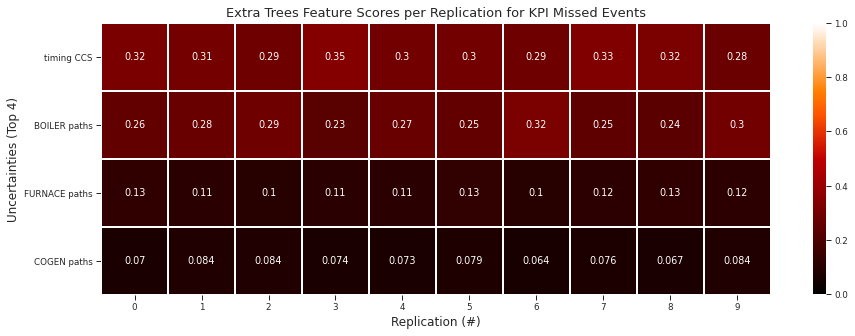

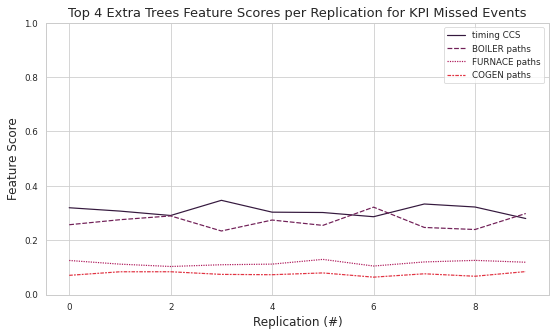

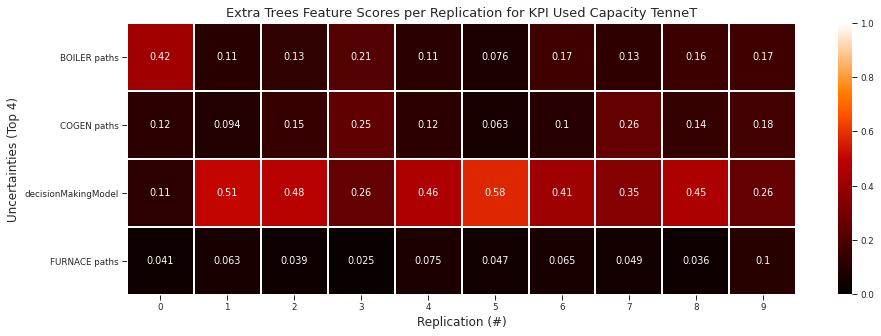

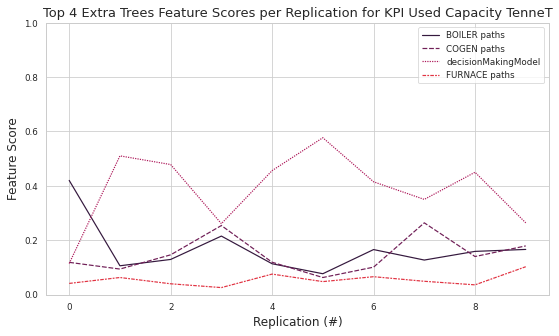

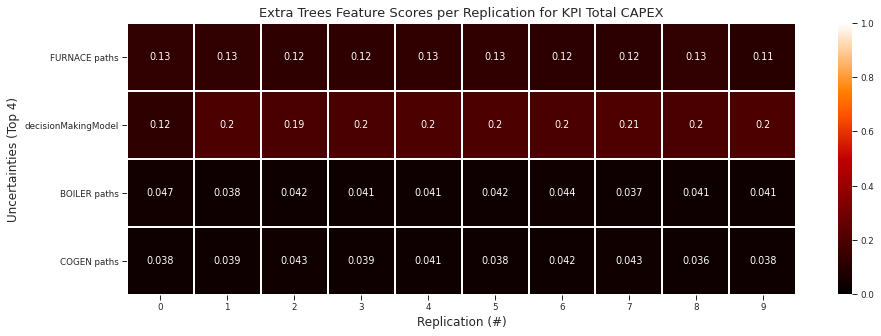

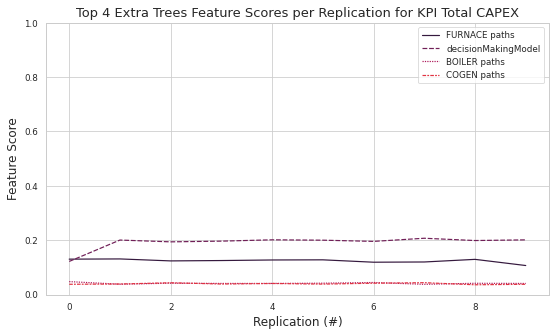

In [ ]:
for ooi in kpi_over_time:
  plot_scores_per_replication_for_ooi(ooi, 4)

In [ ]:
from scipy import stats
stats.describe(outcomes_mean_kpi_over_time['missed_over_time'][:,-1])

DescribeResult(nobs=10997, minmax=(97.0, 208.99999999999997), mean=147.93525506956442, variance=696.1205185166906, skewness=0.06001666775306375, kurtosis=-0.8113642316768237)